## Stack Overflow Dataset

#### About Dataset
Dataset with the text of 10% of questions and answers from the Stack Overflow programming Q&A website.

This is organized as three tables:

Questions contains the title, body, creation date, closed date (if applicable), score, and owner ID for all non-deleted Stack Overflow questions whose Id is a multiple of 10.
Answers contains the body, creation date, score, and owner ID for each of the answers to these questions. The ParentId column links back to the Questions table.
Tags contains the tags on each of these questions

Example projects include:

Identifying tags from question text <br>
Predicting whether questions will be upvoted, downvoted, or closed based on their text <br>
Predicting how long questions will take to answer <br>

- Id is the Id of the post (questions and tags share these)
- A post can have multiple tags



https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/notebook

https://www.kaggle.com/code/niyamatalmass/texts-summarizing-with-the-help-of-spacy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re

In [2]:
#answers = pd.read_csv("data/Answers.csv", encoding="ISO-8859-1")
questions = pd.read_csv("data/Questions.csv", encoding="ISO-8859-1")
tags = pd.read_csv("data/Tags.csv", dtype={'Tag': str})

In [3]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Id            int64  
 1   OwnerUserId   float64
 2   CreationDate  object 
 3   ParentId      int64  
 4   Score         int64  
 5   Body          object 
dtypes: float64(1), int64(3), object(2)
memory usage: 92.2+ MB


In [5]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [6]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [7]:
questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [8]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [9]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [36]:
# Checking number of unique ID:s
# All questions have tags
# Not all questions have answers
print(tags["Id"].nunique()) 
print(questions["Id"].nunique())
#print(answers["ParentId"].nunique())

1264216
1264216
1102568


## Investigating Tags

In [12]:
# A question can have multiple tags
print(len(questions))
print(len(tags))

1264216
3750994


In [ ]:
tags["Tag"] = tags["Tag"].astype(str)

In [3]:
tag_count = pd.DataFrame(tags["Tag"].value_counts()).reset_index()
tag_count = tag_count.rename(columns={"index":"Tag", "Tag":"Count"})
tag_count

,Tag,Count
0,javascript,124155
1,java,115212
2,c#,101186
3,php,98808
4,android,90659
...,...,...
37029,testcasesource,1
37030,google-floodlight,1
37031,iecapt,1
37032,netfs,1


In [155]:
top_tags = tag_count[:100]

/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_18208/797994616.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int), size=4);


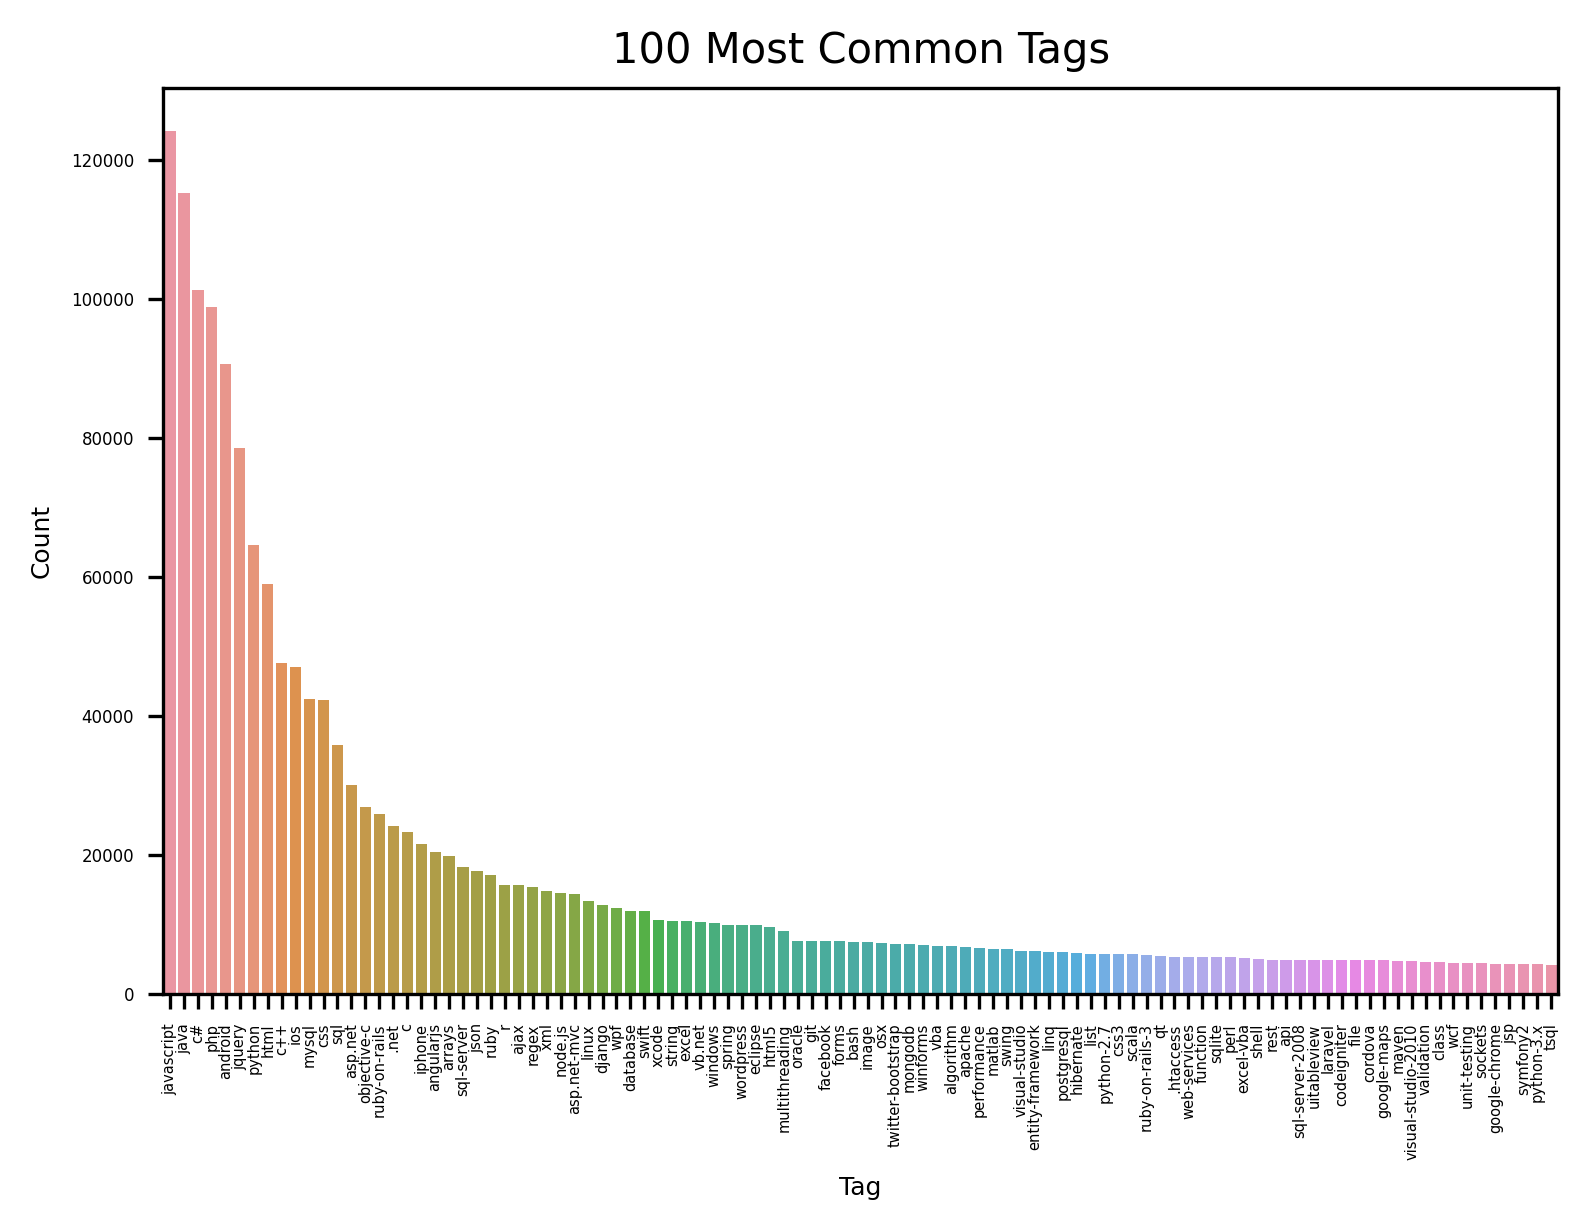

In [159]:
fig, ax = plt.subplots(dpi=300)
ax = sns.barplot(data=top_tags, x="Tag", y="Count");
ax.set_yticklabels(ax.get_yticks().astype(int), size=4);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=3.5);
ax.set_ylabel(ax.get_ylabel(), size=6);
ax.set_xlabel(ax.get_xlabel(), size=6);
ax.set_title("100 Most Common Tags", size=10);

In [160]:
tag_count_dict = {tag:count for tag, count in zip(top_tags["Tag"], top_tags["Count"])}

In [161]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_count_dict)

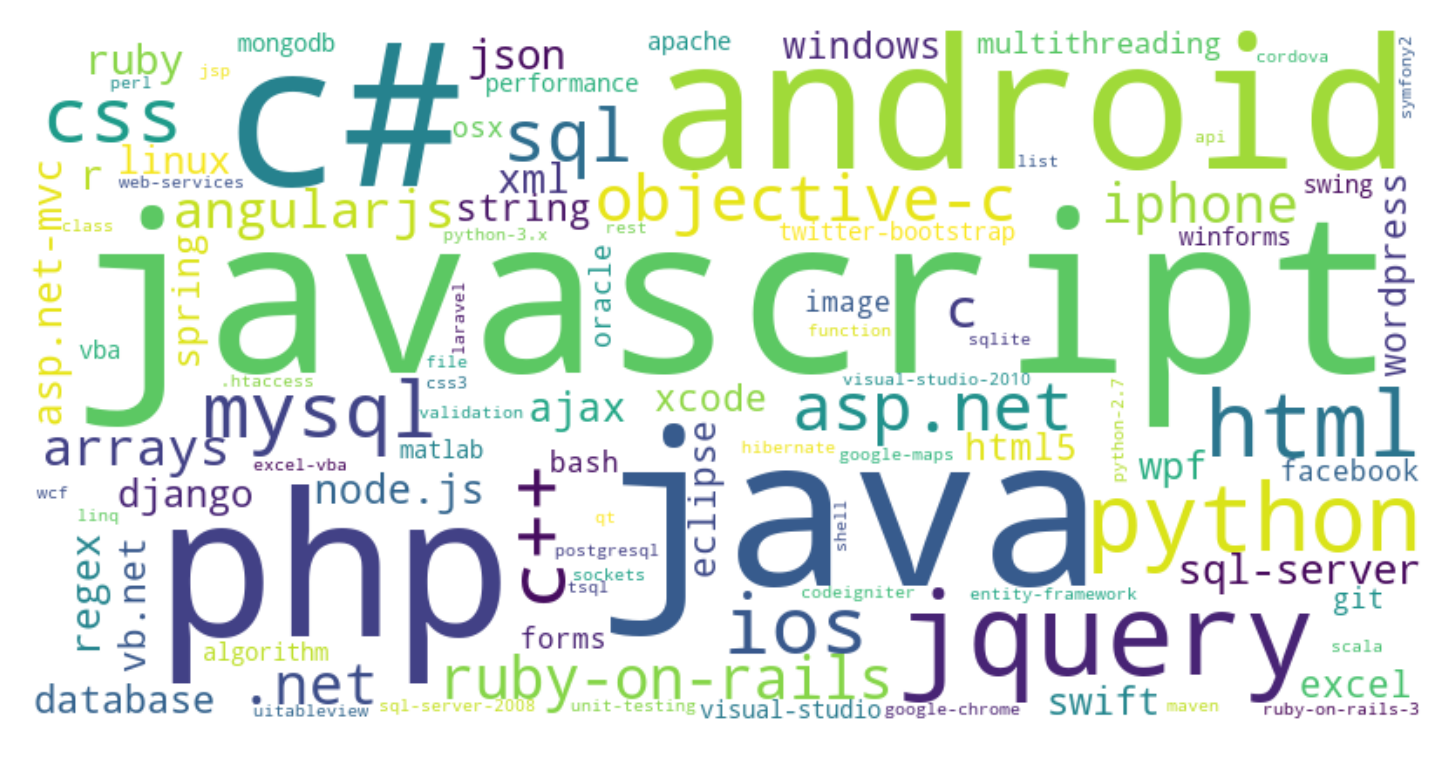

In [162]:
fig, ax = plt.subplots(dpi=300)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off");
plt.savefig("WordCloud")

### Clean Questions

In [4]:
questions = questions.sort_values("Score", ascending=False)

In [102]:
top_questions = questions[:100]
top_questions

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
4907,348170,14069.0,2008-12-07T21:57:46Z,NaN,5190,How to undo 'git add' before commit?,<p>I mistakenly added files using the command:...
441,40480,4315.0,2008-09-02T20:14:29Z,NaN,3613,"Is Java ""pass-by-reference"" or ""pass-by-value""?",<p>I always thought Java was <strong>pass-by-r...
5859,406230,36830.0,2009-01-02T07:30:16Z,NaN,2537,Regular expression to match line that doesn't ...,<p>I know it's possible to match a word and th...
7771,520650,825.0,2009-02-06T15:14:04Z,NaN,2399,Make an existing Git branch track a remote bra...,<p>I know how to make a new branch that tracks...
57759,2669690,151495.0,2010-04-19T18:00:09Z,NaN,2363,Why does Google prepend while(1); to their JSO...,<p>Why does Google prepend <code>while(1);</co...
...,...,...,...,...,...,...,...
122116,4963300,416130.0,2011-02-10T22:05:35Z,NaN,543,Which @NotNull Java annotation should I use?,<p>I'm looking to make my code more readable a...
2700,210120,8508.0,2008-10-16T20:18:22Z,NaN,542,Remove a symlink to a directory,<p>I have a symlink to an important directory....
213583,8072700,344769.0,2011-11-09T22:32:22Z,NaN,534,How to restart Jenkins manually?,<p>I've just started working with Jenkins and ...
39739,1960240,25645.0,2009-12-25T01:31:48Z,NaN,529,jQuery AJAX submit form,<p>I have a form with name orderproductForm an...


In [98]:
def extract_code(text):
    code = re.findall(r"<pre><code>([\s\S]*?)<\/code><\/pre>", text)
    code = " ".join(code)
    return code

In [106]:
def remove_code(text):
    body = re.sub(r"<pre><code>([\s\S]*?)<\/code><\/pre>", "", text)
    return body

In [107]:
top_questions["Code"] = top_questions["Body"].apply(lambda x: extract_code(x))

/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_749/1588553460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_questions["Code"] = top_questions["Body"].apply(lambda x: extract_code(x))


In [108]:
top_questions["Body"] = top_questions["Body"].apply(lambda x: remove_code(x))

/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_749/4148359452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_questions["Body"] = top_questions["Body"].apply(lambda x: remove_code(x))


In [109]:
top_questions

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Code
4907,348170,14069.0,2008-12-07T21:57:46Z,NaN,5190,How to undo 'git add' before commit?,<p>I mistakenly added files using the command:...,git add myfile.txt\n
441,40480,4315.0,2008-09-02T20:14:29Z,NaN,3613,"Is Java ""pass-by-reference"" or ""pass-by-value""?",<p>I always thought Java was <strong>pass-by-r...,
5859,406230,36830.0,2009-01-02T07:30:16Z,NaN,2537,Regular expression to match line that doesn't ...,<p>I know it's possible to match a word and th...,"hoho\nhihi\nhaha\nhede\n # grep ""Regex for doe..."
7771,520650,825.0,2009-02-06T15:14:04Z,NaN,2399,Make an existing Git branch track a remote bra...,<p>I know how to make a new branch that tracks...,
57759,2669690,151495.0,2010-04-19T18:00:09Z,NaN,2363,Why does Google prepend while(1); to their JSO...,<p>Why does Google prepend <code>while(1);</co...,"while(1);[['u',[['smsSentFlag','false'],['hide..."
...,...,...,...,...,...,...,...,...
122116,4963300,416130.0,2011-02-10T22:05:35Z,NaN,543,Which @NotNull Java annotation should I use?,<p>I'm looking to make my code more readable a...,
2700,210120,8508.0,2008-10-16T20:18:22Z,NaN,542,Remove a symlink to a directory,<p>I have a symlink to an important directory....,
213583,8072700,344769.0,2011-11-09T22:32:22Z,NaN,534,How to restart Jenkins manually?,<p>I've just started working with Jenkins and ...,
39739,1960240,25645.0,2009-12-25T01:31:48Z,NaN,529,jQuery AJAX submit form,<p>I have a form with name orderproductForm an...,"jQuery.get(""myurl"",\n {action : docum..."


In [110]:
top_questions["Body"].iloc[0]

"<p>I mistakenly added files using the command:</p>\n\n\n\n<p>I have not yet run <code>git commit</code>. Is there a way to undo this, so these files won't be included in the commit?</p>\n"

In [111]:
top_questions["Code"].iloc[0]

'git add myfile.txt\n'

In [113]:
top_questions["Body"] = top_questions["Body"].apply(lambda x: BeautifulSoup(x).get_text()) 

/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_749/1474241577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_questions["Body"] = top_questions["Body"].apply(lambda x: BeautifulSoup(x).get_text())


In [114]:
top_questions["Code"] = top_questions["Code"].apply(lambda x: BeautifulSoup(x).get_text()) 

/Users/anna-mariasjolund/.local/share/virtualenvs/AI21-Dl-project-tagging-sgAXYyVA/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_749/124170657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_questions["Code"] = top_questions["Code"].apply(lambda x: BeautifulSoup(x).get_text())


In [116]:
top_questions["Body"].iloc[0]

"I mistakenly added files using the command:\nI have not yet run git commit. Is there a way to undo this, so these files won't be included in the commit?\n"

In [117]:
top_questions["Body"].iloc[2]

"I know it's possible to match a word and then reverse the matches using other tools (e.g. grep -v). However, I'd like to know if it's possible to match lines that don't contain a specific word (e.g. hede) using a regular expression? \nInput:\nCode:\n\nDesired output: \n"

In [115]:
top_questions["Code"].iloc[0]

'git add myfile.txt\n'

In [118]:
top_questions["Code"].iloc[2]

'hoho\nhihi\nhaha\nhede\n # grep "Regex for doesn\'t contain hede" Input\n hoho\nhihi\nhaha\n'